In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cab
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('darkgrid',{'font.sans-serif':'Microsoft YaHei'})
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
import math
import sklearn.metrics as metrics
import os, datetime, sys, random, time
import matplotlib.gridspec as gridspec
from mlxtend import classifier
import warnings
warnings.filterwarnings('ignore')
from scipy import stats, special
import shap
%matplotlib inline

## 导入数据 <a class="anchor" id="2"></a>

In [2]:
df_train = pd.read_csv("cs-training.csv",index_col=0)
df_test = pd.read_csv("cs-test.csv",index_col=0)
df_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


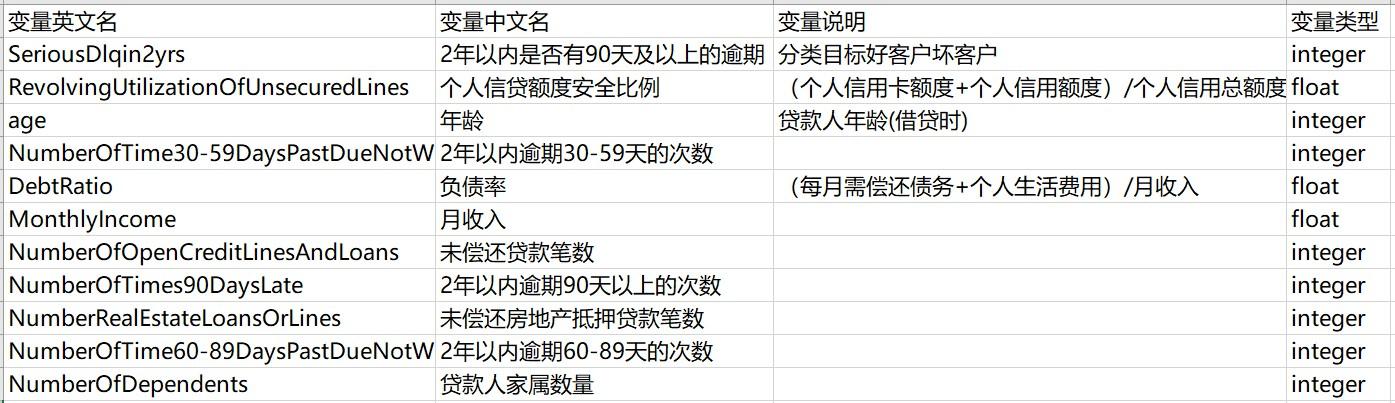

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [4]:
df_train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


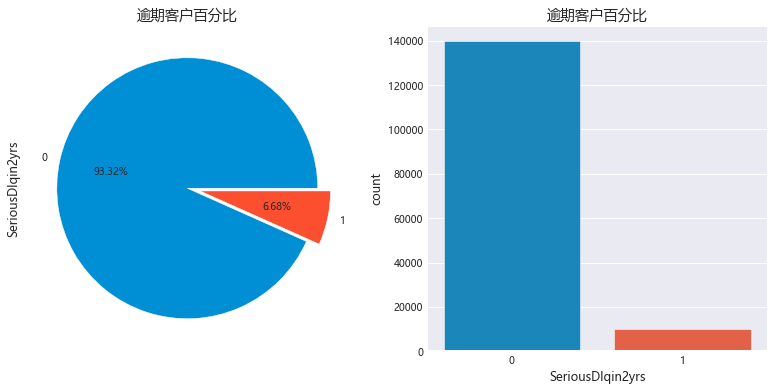

逾期客户的百分比:0.06684


In [5]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
df_train['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.2f%%',ax=axes[0])
axes[0].set_title('逾期客户百分比')
sns.countplot('SeriousDlqin2yrs',data=df_train,ax=axes[1])
axes[1].set_title('逾期客户百分比')
plt.show()
print("逾期客户的百分比:{}".format(df_train["SeriousDlqin2yrs"].sum() / len(df_train)))

### 数据探索（异常值检测）

Text(0.5, 1.0, 'Correlation Matrix (热力图)')

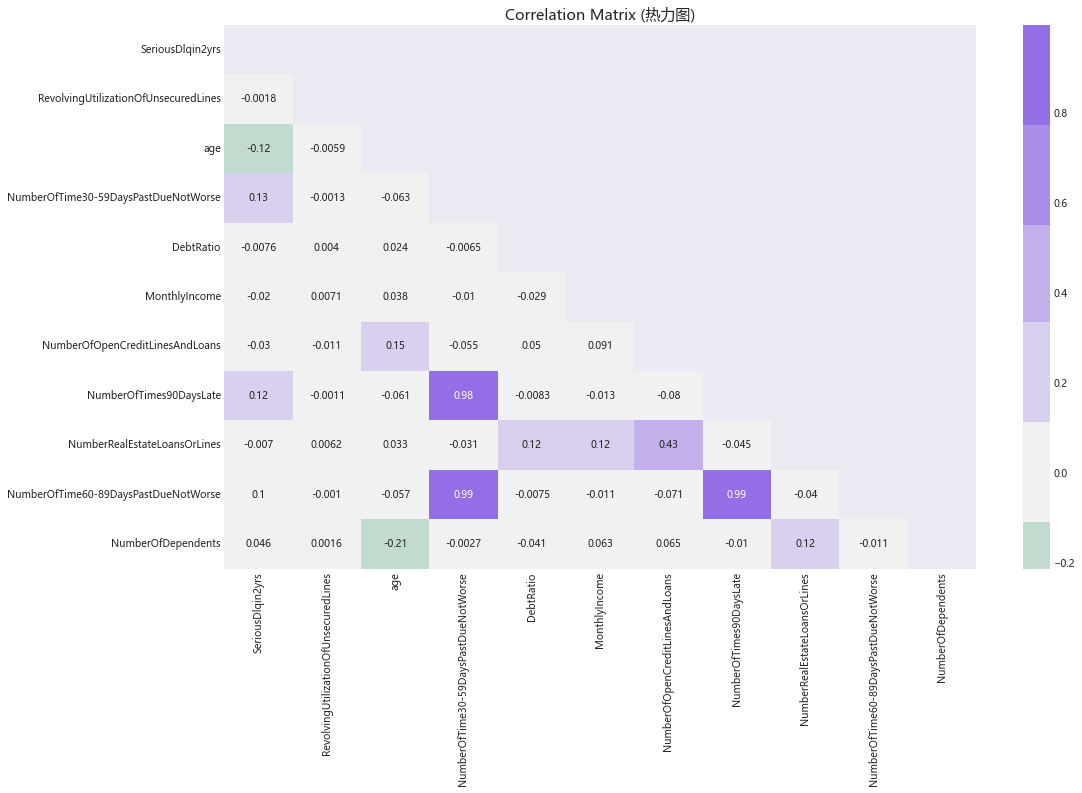

In [6]:
fig = plt.figure(figsize = [15,10])
mask = np.zeros_like(df_train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_train.corr(), cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9), mask = mask, annot=True, center = 0)
plt.title("Correlation Matrix (热力图)", fontsize = 15)

### RevolvingUtilizationOfUnsecuredLines（个人信贷额度安全比例）

In [7]:
df_train["RevolvingUtilizationOfUnsecuredLines"].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [8]:
default_prop = []
for i in range(int(df_train["RevolvingUtilizationOfUnsecuredLines"].max())):
    temp_ = df_train.loc[df_train["RevolvingUtilizationOfUnsecuredLines"] >= i]
    default_prop.append([i, temp_["SeriousDlqin2yrs"].mean()])
default_prop

[[0, 0.06684],
 [1, 0.37177950868783705],
 [2, 0.14555256064690028],
 [3, 0.09931506849315068],
 [4, 0.08679245283018867],
 [5, 0.07874015748031496],
 [6, 0.07692307692307693],
 [7, 0.0778688524590164],
 [8, 0.07407407407407407],
 [9, 0.07053941908713693],
 [10, 0.07053941908713693],
 [11, 0.07053941908713693],
 [12, 0.06666666666666667],
 [13, 0.058823529411764705],
 [14, 0.058823529411764705],
 [15, 0.05531914893617021],
 [16, 0.05531914893617021],
 [17, 0.05531914893617021],
 [18, 0.05531914893617021],
 [19, 0.05555555555555555],
 [20, 0.05555555555555555],
 [21, 0.05555555555555555],
 [22, 0.05555555555555555],
 [23, 0.05555555555555555],
 [24, 0.05555555555555555],
 [25, 0.05555555555555555],
 [26, 0.05555555555555555],
 [27, 0.05555555555555555],
 [28, 0.05555555555555555],
 [29, 0.05555555555555555],
 [30, 0.05150214592274678],
 [31, 0.05150214592274678],
 [32, 0.05150214592274678],
 [33, 0.05150214592274678],
 [34, 0.05150214592274678],
 [35, 0.05150214592274678],
 [36, 0.05150

Text(0.5, 1.0, '逾期客户比例与个人信贷额度安全比例的关系')

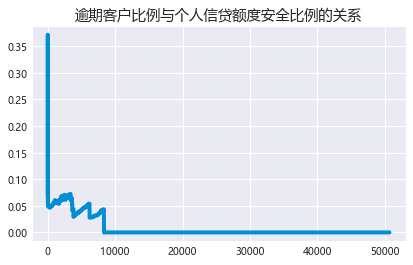

In [9]:
sns.lineplot(x=[i[0] for i in default_prop], y=[i[1] for i in default_prop])
plt.title("逾期客户比例与个人信贷额度安全比例的关系")

通过以上分析统计，个人信贷额度安全比例大于1的客户作为异常值直接删除

In [10]:
df_train =df_train[(df_train['RevolvingUtilizationOfUnsecuredLines']>=0)&(df_train['RevolvingUtilizationOfUnsecuredLines']<=1)]

### age

In [11]:
df_train["age"].describe()

count    146679.000000
mean         52.481766
std          14.763178
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

<AxesSubplot:xlabel='age', ylabel='Density'>

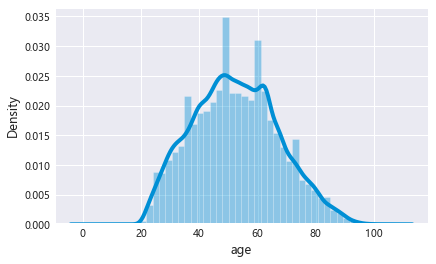

In [12]:
sns.distplot(df_train["age"])

<AxesSubplot:xlabel='age', ylabel='Density'>

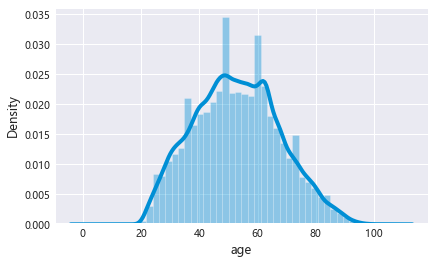

In [13]:
sns.distplot(df_train.loc[df_train["SeriousDlqin2yrs"] == 0]["age"])

<AxesSubplot:xlabel='age', ylabel='Density'>

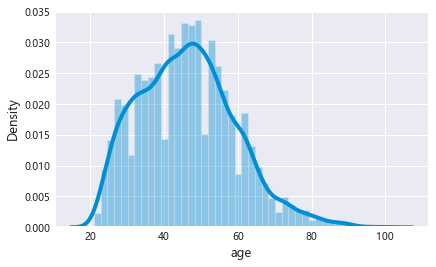

In [14]:
sns.distplot(df_train.loc[df_train["SeriousDlqin2yrs"] == 1]["age"])

[Text(1, 0, '借贷人年龄')]

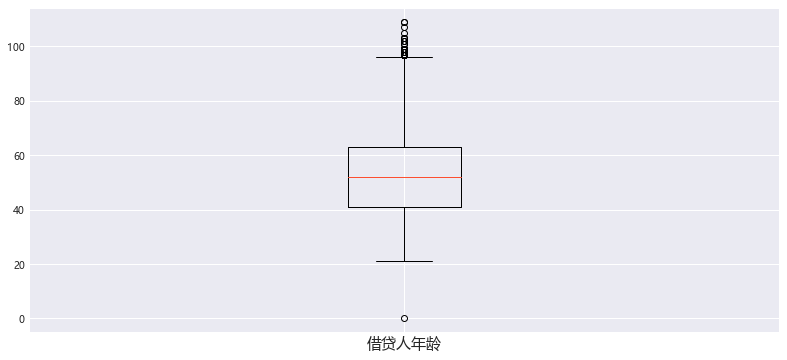

In [15]:
fig=plt.figure(figsize=(12,6))
ax1=fig.add_subplot()
ax1.boxplot(df_train['age'])
ax1.set_xticklabels(["借贷人年龄"], fontsize=15)

In [16]:
df_train["age"].quantile(0.99)

87.0

通过以上分析统计和信贷常识，借贷人年龄小于22岁和大于87的客户作为异常值直接删除

In [17]:
df_train =df_train[(df_train['age']>=22)&(df_train['age']<=87)]

逾期90天的次数
逾期60-89天次数
逾期30-59天次数

In [18]:
late_pay_cols = ["NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse",
                "NumberOfTime30-59DaysPastDueNotWorse"]
df_train["NumberOfTimes90DaysLate"].value_counts().sort_index()

0     137945
1       4724
2       1309
3        532
4        230
5        100
6         62
7         26
8         15
9         16
10         7
11         4
12         1
13         2
14         2
15         1
17         1
96         5
98       242
Name: NumberOfTimes90DaysLate, dtype: int64

In [19]:
df_train["NumberOfTime60-89DaysPastDueNotWorse"].value_counts().sort_index()

0     138591
1       5127
2        890
3        241
4         79
5         26
6         13
7          6
8          2
9          1
11         1
96         5
98       242
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

In [20]:
df_train["NumberOfTime30-59DaysPastDueNotWorse"].value_counts().sort_index()

0     123077
1      15115
2       4143
3       1523
4        636
5        285
6        114
7         43
8         23
9         11
10         3
11         1
12         2
13         1
96         5
98       242
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64

In [21]:
distinct_triples_counts = dict()
for arr in df_train.loc[df_train["NumberOfTimes90DaysLate"] > 17][late_pay_cols].values:
    triple = ",".join(list(map(str, arr)))
    if triple not in distinct_triples_counts:
        distinct_triples_counts[triple] = 0
    else:
        distinct_triples_counts[triple] += 1
distinct_triples_counts

{'98,98,98': 241, '96,96,96': 4}

[Text(1, 0, '逾期30-59天笔数'), Text(2, 0, '逾期60-89天笔数'), Text(3, 0, '逾期90天笔数')]

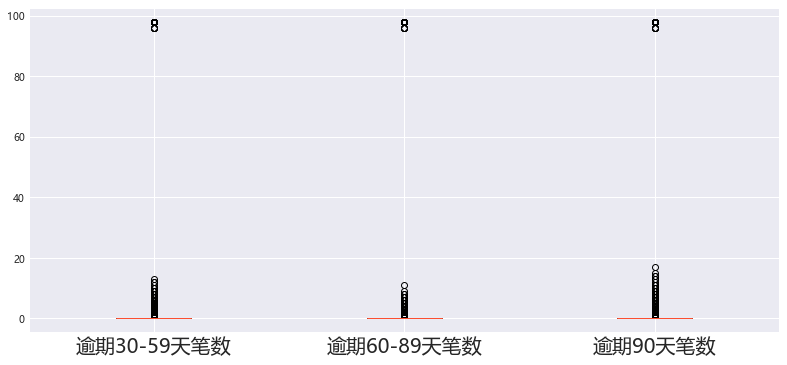

In [22]:
fig=plt.figure(figsize=(12,6))
ax1=fig.add_subplot()
ax1.boxplot([df_train["NumberOfTime30-59DaysPastDueNotWorse"],df_train["NumberOfTime60-89DaysPastDueNotWorse"],df_train["NumberOfTimes90DaysLate"]])
ax1.set_xticklabels(["逾期30-59天笔数","逾期60-89天笔数","逾期90天笔数"], fontsize=20)

通过以上箱型图，分别删除逾期30-59天笔数，逾期60-89天笔数，逾期90天笔数中的超级离群数据

In [23]:
df_train =df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse']<14]
df_train =df_train[df_train['NumberOfTime60-89DaysPastDueNotWorse']<12]
df_train =df_train[df_train['NumberOfTimes90DaysLate']<18]

### 负债率和月收入

In [24]:
df_train["DebtRatio"].describe()

count    144977.000000
mean        358.107351
std        2060.372940
min           0.000000
25%           0.178302
50%           0.367945
75%           0.865658
max      329664.000000
Name: DebtRatio, dtype: float64

In [25]:
df_train.loc[df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.99)][["DebtRatio", "MonthlyIncome", "SeriousDlqin2yrs"]].describe()

,DebtRatio,MonthlyIncome,SeriousDlqin2yrs
count,1450.000000,81.000000,1450.000000
mean,8661.052759,0.086420,0.071034
std,17129.858665,0.282734,0.256971
min,5008.000000,0.000000,0.000000
25%,5491.500000,0.000000,0.000000
50%,6216.000000,0.000000,0.000000
75%,7810.750000,0.000000,0.000000
max,329664.000000,1.000000,1.000000


[Text(1, 0, '负债率')]

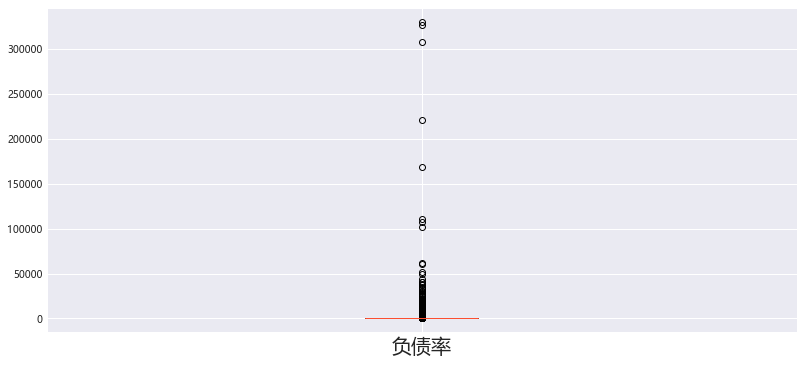

In [26]:
fig=plt.figure(figsize=(12,6))
ax1=fig.add_subplot()
ax1.boxplot(df_train["DebtRatio"])
ax1.set_xticklabels(["负债率"], fontsize=20)

<AxesSubplot:ylabel='MonthlyIncome'>

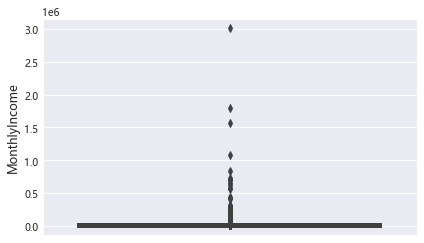

In [27]:
sns.boxplot(y=df_train["MonthlyIncome"])

In [28]:
df_train["DebtRatio"].quantile(0.99)

5007.239999999991

In [29]:
df_train["MonthlyIncome"].quantile(0.99)

25000.0

通过以上箱型图，分别删除负债率大于4980，月收入大于23000美元的超级离群数据

In [30]:
df_train =df_train[df_train['DebtRatio']<=4980]
df_train =df_train[df_train['MonthlyIncome']<=23000]

### 未偿还贷款笔数

In [31]:
df_train["NumberOfOpenCreditLinesAndLoans"].describe()

count    114937.000000
mean          8.804093
std           5.147923
min           0.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [32]:
df_train["NumberOfOpenCreditLinesAndLoans"].value_counts()

6     10337
7     10321
8      9900
5      9550
9      9102
4      8225
10     7808
11     6773
3      6201
12     5739
13     4697
2      4289
14     3793
15     3045
1      2701
16     2503
17     1961
18     1541
19     1185
0       991
20      987
21      712
22      559
23      445
24      341
25      277
26      202
27      164
28      125
29       95
30       72
31       62
32       48
33       34
34       30
35       22
36       16
38       10
39        9
40        8
42        7
45        6
37        6
43        5
48        5
54        4
49        4
41        3
52        3
56        2
46        2
51        2
50        2
47        2
44        1
57        1
58        1
53        1
Name: NumberOfOpenCreditLinesAndLoans, dtype: int64

[Text(1, 0, '未偿还贷款笔数')]

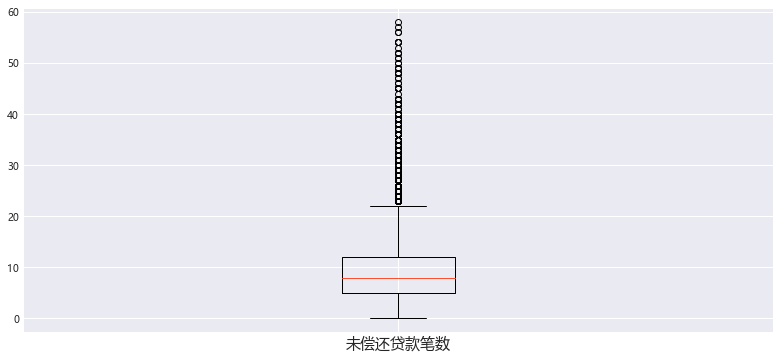

In [33]:
fig=plt.figure(figsize=(12,6))
ax1=fig.add_subplot()
ax1.boxplot(df_train['NumberOfOpenCreditLinesAndLoans'])
ax1.set_xticklabels(["未偿还贷款笔数"], fontsize=15)

In [34]:
df_train["NumberOfOpenCreditLinesAndLoans"].quantile(0.99)

25.0

### 未偿还房地产抵押贷款笔数

In [35]:
df_train["NumberRealEstateLoansOrLines"].describe()

count    114937.000000
mean          1.055561
std           1.117805
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

In [36]:
df_train["NumberRealEstateLoansOrLines"].value_counts()

0     40833
1     40412
2     25757
3      5109
4      1713
5       525
6       248
7       121
8        72
9        55
10       29
11       14
12       14
13       12
14        6
15        5
16        3
17        2
19        2
54        1
18        1
23        1
25        1
20        1
Name: NumberRealEstateLoansOrLines, dtype: int64

<AxesSubplot:xlabel='NumberRealEstateLoansOrLines', ylabel='count'>

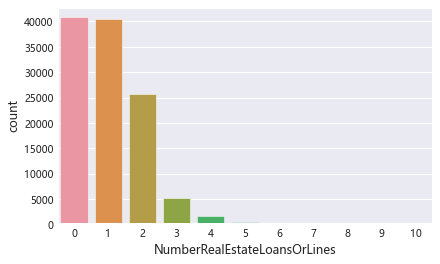

In [37]:
sns.countplot(x="NumberRealEstateLoansOrLines", data=df_train.loc[df_train["NumberRealEstateLoansOrLines"] <= 10])

In [38]:
df_train["NumberRealEstateLoansOrLines"].quantile(0.99)

4.0

In [39]:
df_train.loc[df_train["NumberRealEstateLoansOrLines"] > 13]["SeriousDlqin2yrs"].describe()

count    23.000000
mean      0.217391
std       0.421741
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: SeriousDlqin2yrs, dtype: float64

### 家属人数

In [40]:
df_train["NumberOfDependents"].describe()

count    114937.000000
mean          0.847516
std           1.144352
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          20.000000
Name: NumberOfDependents, dtype: float64

In [41]:
df_train["NumberOfDependents"].value_counts()

0.0     62671
1.0     23344
2.0     17266
3.0      8306
4.0      2495
5.0       634
6.0       143
7.0        46
8.0        21
10.0        5
9.0         4
20.0        1
13.0        1
Name: NumberOfDependents, dtype: int64

In [42]:
df_train.loc[df_train["NumberOfDependents"] <= 10]["SeriousDlqin2yrs"].describe()

count    114935.000000
mean          0.062044
std           0.241236
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: SeriousDlqin2yrs, dtype: float64

<AxesSubplot:xlabel='NumberOfDependents', ylabel='count'>

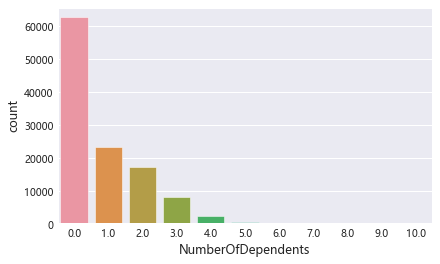

In [43]:
sns.countplot(x="NumberOfDependents", data=df_train.loc[df_train["NumberOfDependents"] <= 10])

In [44]:
def MissingHandler(df):
    DataMissing = df.isnull().sum()*100/len(df)
    DataMissingByColumn = pd.DataFrame({'Percentage Nulls':DataMissing})
    DataMissingByColumn.sort_values(by='Percentage Nulls',ascending=False,inplace=True)
    return DataMissingByColumn[DataMissingByColumn['Percentage Nulls']>0]

MissingHandler(df_train)

,Percentage Nulls


### 数据清洗
通过fillna函数将数据中的Nan填充为中位数

In [45]:
df_train = df_train.fillna(df_train.median())
print(df_train.isnull().sum())

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


### 特征工程

构建家庭人均收入，月负债金额，退休人员，非房屋抵押贷款笔数，房贷人员，多房产人员，月收入（单位千元）共七项特征增强模型的鲁棒性

In [46]:
df_train['MonthlyIncomePerPerson'] = df_train['MonthlyIncome']/(df_train['NumberOfDependents']+1)
df_train['MonthlyIncomePerPerson'].fillna(0, inplace=True)

df_train['MonthlyDebt'] = df_train['MonthlyIncome']*df_train['DebtRatio']
df_train['MonthlyDebt'].fillna(df_train['DebtRatio'],inplace=True)
df_train['MonthlyDebt'] = np.where(df_train['MonthlyDebt']==0, df_train['DebtRatio'],df_train['MonthlyDebt'])

df_train['isRetired'] = np.where((df_train['age'] > 65), 1, 0)

df_train['RevolvingLines'] = df_train['NumberOfOpenCreditLinesAndLoans']-df_train['NumberRealEstateLoansOrLines']

df_train['hasRevolvingLines']=np.where((df_train['RevolvingLines']>0),1,0)

df_train['hasMultipleRealEstates'] = np.where((df_train['NumberRealEstateLoansOrLines']>=2),1,0)

df_train['incomeDivByThousand'] = df_train['MonthlyIncome']/1000

df_train.to_csv("data.csv")#将数据清洗的样本保存到本地准备提交到Tableau和Spark数据库进行处理

In [47]:
df_train.shape

(114937, 18)

In [48]:
df_train.head(20)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncomePerPerson,MonthlyDebt,isRetired,RevolvingLines,hasRevolvingLines,hasMultipleRealEstates,incomeDivByThousand
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,3040.000000,7323.197016,0,7,1,1,9.120
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,1300.000000,316.878123,0,4,1,0,2.600
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,3042.000000,258.914887,0,2,1,0,3.042
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,3300.000000,118.963951,0,5,1,0,3.300
6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0,1750.000000,1314.624392,1,2,1,0,3.500
8,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0,3500.000000,734.790059,0,8,1,0,3.500
11,0,0.644226,30,0,0.309476,2500.0,5,0,0,0,0.0,2500.000000,773.690525,0,5,1,0,2.500
12,0,0.018798,51,0,0.531529,6501.0,7,0,2,0,2.0,2167.000000,3455.468469,0,5,1,1,6.501
13,0,0.010352,46,0,0.298354,12454.0,13,0,2,0,2.0,4151.333333,3715.701650,0,11,1,1,12.454
14,1,0.964673,40,3,0.382965,13700.0,9,3,1,1,2.0,4566.666667,5246.617034,0,8,1,0,13.700


建模

70%作为模型的训练集，留30%作为模型的验证集

In [49]:
SeriousDlqIn2Yrs = df_train['SeriousDlqin2yrs']
df_train.drop('SeriousDlqin2yrs', axis = 1 , inplace = True)
trainDF = df_train[:len(df_train)]
print(trainDF.shape)

(114937, 17)


In [50]:
X_train, X_test, y_train, y_test = train_test_split(trainDF.to_numpy(),SeriousDlqIn2Yrs.to_numpy(), test_size=0.3, random_state=37)

In [51]:
print('bad rate is: ',y_train.mean())

bad rate is:  0.06131377788826052


逻辑回归LR建模

In [52]:
model_LR = LogisticRegression(random_state=37).fit(X_train,y_train)

In [53]:
#在验证集上看性能
model_LR.score(X_test,y_test)

0.9372426193376254

In [54]:
yPredLR = model_LR.predict_proba(X_test)
yPredLR = yPredLR[:,1]

In [55]:
yTestPredLR = model_LR.predict(X_test)
print(metrics.classification_report(y_test,yTestPredLR))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     32284
           1       0.54      0.11      0.19      2198

    accuracy                           0.94     34482
   macro avg       0.74      0.55      0.58     34482
weighted avg       0.92      0.94      0.92     34482



In [56]:
metrics.confusion_matrix(y_test,yTestPredLR)

array([[32070,   214],
       [ 1950,   248]], dtype=int64)

In [57]:
LRMetrics = pd.DataFrame({'Model': 'LogisticRegression', 
                            'MSE': round(metrics.mean_squared_error(y_test, yTestPredLR)*100,2),
                            'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test, yTestPredLR)*100),2),
                            'MAE' : round(metrics.mean_absolute_error(y_test, yTestPredLR)*100,2),
                            'MSLE' : round(metrics.mean_squared_log_error(y_test, yTestPredLR)*100,2), 
                            'RMSLE' : round(np.sqrt(metrics.mean_squared_log_error(y_test, yTestPredLR)*100),2),
                            'Accuracy Train' : round(model_LR.score(X_train, y_train) * 100,2),
                            'Accuracy Test' : round(model_LR.score(X_test, y_test) * 100,2),
                            'F-Beta Score (β=2)' : round(metrics.fbeta_score(y_test, yTestPredLR, beta=2)*100,2)},index=[0])

LRMetrics

,Model,MSE,RMSE,MAE,MSLE,RMSLE,Accuracy Train,Accuracy Test,F-Beta Score (β=2)
0,LogisticRegression,6.28,2.51,6.28,3.02,1.74,93.99,93.72,13.4


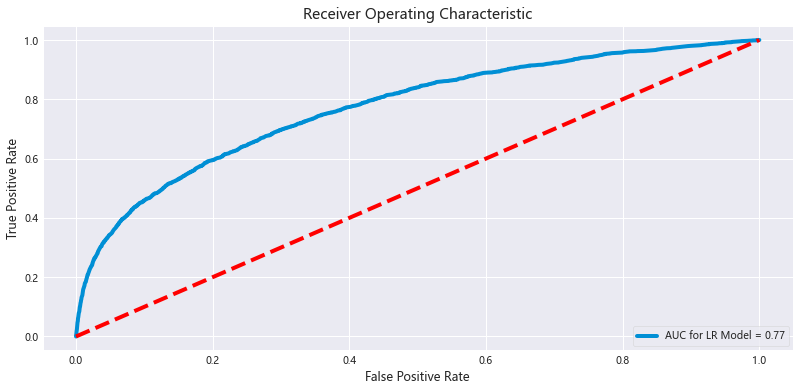

In [58]:
fpr_LR,tpr_LR,_ = metrics.roc_curve(y_test,yPredLR)
ROC_AUC_LR= metrics.auc(fpr_LR, tpr_LR)
plt.figure(figsize=(12,6))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr_LR, tpr_LR, label = 'AUC for LR Model = %0.2f' % ROC_AUC_LR)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

LightgGBM模型

In [59]:
lgbAttributes = lgb.LGBMClassifier(objective='binary', n_jobs=-1, random_state=37, importance_type='gain')

lgbParameters = {
    'max_depth' : [2,3,4,5],
    'learning_rate': [0.05, 0.1,0.125,0.15],
    'colsample_bytree' : [0.2,0.4,0.6,0.8,1],
    'n_estimators' : [400,500,600,700,800,900],
    'min_split_gain' : [0.15,0.20,0.25,0.3,0.35], 
    'subsample': [0.6,0.7,0.8,0.9,1],
    'min_child_weight': [6,7,8,9,10],
    'scale_pos_weight': [10,15,20],
    'min_data_in_leaf' : [100,200,300,400,500,600,700,800,900],
    'num_leaves' : [20,30,40,50,60,70,80,90,100]
}

model_LGB = model_selection.RandomizedSearchCV(lgbAttributes, param_distributions = lgbParameters, cv = 5, random_state=37)

model_LGB.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(importance_type='gain',
                                            objective='binary',
                                            random_state=37),
                   param_distributions={'colsample_bytree': [0.2, 0.4, 0.6, 0.8,
                                                             1],
                                        'learning_rate': [0.05, 0.1, 0.125,
                                                          0.15],
                                        'max_depth': [2, 3, 4, 5],
                                        'min_child_weight': [6, 7, 8, 9, 10],
                                        'min_data_in_leaf': [100, 200, 300, 400,
                                                             500, 600, 700, 800,
                                                             900],
                                        'min_split_gain': [0.15, 0.2, 0.25, 0.3,
                                       

In [60]:
bestEstimatorLGB = model_LGB.best_estimator_
bestEstimatorLGB

LGBMClassifier(colsample_bytree=0.8, importance_type='gain', learning_rate=0.15,
               max_depth=5, min_child_weight=10, min_data_in_leaf=300,
               min_split_gain=0.35, n_estimators=600, num_leaves=70,
               objective='binary', random_state=37, scale_pos_weight=10,
               subsample=0.6)

In [61]:
bestEstimatorLGB = lgb.LGBMClassifier(colsample_bytree=0.8, importance_type='gain', learning_rate=0.15,
               max_depth=5, min_child_weight=10, min_data_in_leaf=300,
               min_split_gain=0.35, n_estimators=600, num_leaves=70,
               objective='binary', random_state=37, scale_pos_weight=10,
               subsample=0.6).fit(X_train,y_train,feature_name=trainDF.columns.to_list())

In [62]:
yPredLGB = bestEstimatorLGB.predict_proba(X_test)
yPredLGB = yPredLGB[:,1]

In [63]:
yTestPredLGB = bestEstimatorLGB.predict(X_test)
print(metrics.classification_report(y_test,yTestPredLGB))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     32284
           1       0.25      0.58      0.35      2198

    accuracy                           0.86     34482
   macro avg       0.61      0.73      0.64     34482
weighted avg       0.92      0.86      0.89     34482



In [64]:
metrics.confusion_matrix(y_test,yTestPredLGB)

array([[28447,  3837],
       [  919,  1279]], dtype=int64)

In [65]:
LGBMMetrics = pd.DataFrame({'Model': 'LightGBM', 
                            'MSE': round(metrics.mean_squared_error(y_test, yTestPredLGB)*100,2),
                            'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test, yTestPredLGB)*100),2),
                            'MAE' : round(metrics.mean_absolute_error(y_test, yTestPredLGB)*100,2),
                            'MSLE' : round(metrics.mean_squared_log_error(y_test, yTestPredLGB)*100,2), 
                            'RMSLE' : round(np.sqrt(metrics.mean_squared_log_error(y_test, yTestPredLGB)*100),2),
                            'Accuracy Train' : round(bestEstimatorLGB.score(X_train, y_train) * 100,2),
                            'Accuracy Test' : round(bestEstimatorLGB.score(X_test, y_test) * 100,2),
                            'F-Beta Score (β=2)' : round(metrics.fbeta_score(y_test, yTestPredLGB, beta=2)*100,2)},index=[1])

LGBMMetrics

,Model,MSE,RMSE,MAE,MSLE,RMSLE,Accuracy Train,Accuracy Test,F-Beta Score (β=2)
1,LightGBM,13.79,3.71,13.79,6.63,2.57,88.43,86.21,45.98


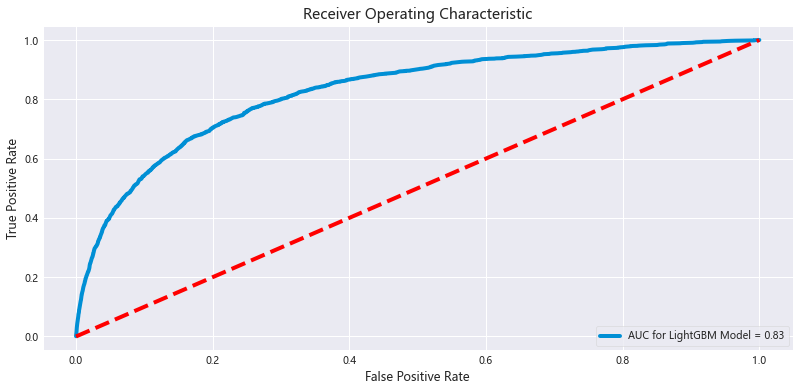

In [66]:
fpr_LGB,tpr_LGB,_ = metrics.roc_curve(y_test,yPredLGB)
ROC_AUC_LGB= metrics.auc(fpr_LGB, tpr_LGB)
plt.figure(figsize=(12,6))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr_LGB, tpr_LGB, label = 'AUC for LightGBM Model = %0.2f' % ROC_AUC_LGB)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

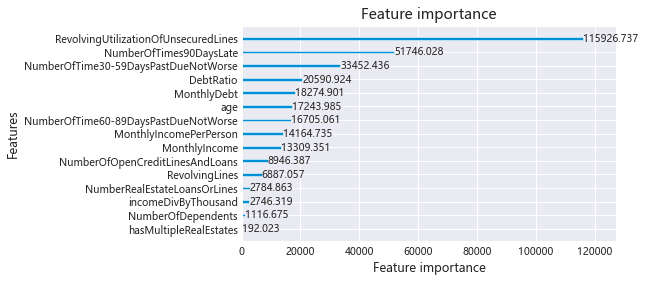

In [67]:
lgb.plot_importance(bestEstimatorLGB, importance_type='gain')

XGBoost模型

In [68]:
xgbAttribute = xgb.XGBClassifier(n_jobs=-1)

xgbParameters = {
    'max_depth' : [2,3,4,5,6,7,8],
    'learning_rate':[0.05,0.1,0.125,0.15],
    'colsample_bytree' : [0.2,0.4,0.6,0.8,1],
    'n_estimators' : [400,500,600,700,800,900],
    'gamma':[0.15,0.20,0.25,0.3,0.35],
    'subsample': [0.6,0.7,0.8,0.9,1],
    'min_child_weight': [6,7,8,9,10],
    'scale_pos_weight': [10,15,20]
    
}

xgbModel = model_selection.RandomizedSearchCV(xgbAttribute, param_distributions = xgbParameters, cv = 5, random_state=37)

xgbModel.fit(X_train,y_train)

[18:48:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[19:08:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:08:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:09:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:09:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           validate_parameters=None,
                                           verbosity=None),
                   param_distributions={'colsample_b

In [69]:
bestEstimatorXGB = xgbModel.best_estimator_
bestEstimatorXGB

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.35, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=8,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=900, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=15, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
bestEstimatorXGB = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.35, 
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=8,
              min_child_weight=10, monotone_constraints='()',
              n_estimators=900, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=15, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None).fit(X_train,y_train)

[19:24:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [71]:
yPredXGB = bestEstimatorXGB.predict_proba(X_test)
yPredXGB = yPredXGB[:,1]

yTestPredXGB = bestEstimatorXGB.predict(X_test)
print(metrics.classification_report(y_test,yTestPredXGB))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     32284
           1       0.32      0.33      0.32      2198

    accuracy                           0.91     34482
   macro avg       0.64      0.64      0.64     34482
weighted avg       0.91      0.91      0.91     34482



In [72]:
metrics.confusion_matrix(y_test,yTestPredXGB)

array([[30717,  1567],
       [ 1468,   730]], dtype=int64)

In [73]:
XGBMetrics = pd.DataFrame({'Model': 'XGBoost', 
                            'MSE': round(metrics.mean_squared_error(y_test, yTestPredXGB)*100,2),
                            'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test, yTestPredXGB)*100),2),
                            'MAE' : round(metrics.mean_absolute_error(y_test, yTestPredXGB)*100,2),
                            'MSLE' : round(metrics.mean_squared_log_error(y_test, yTestPredXGB)*100,2), 
                            'RMSLE' : round(np.sqrt(metrics.mean_squared_log_error(y_test, yTestPredXGB)*100),2),
                            'Accuracy Train' : round(bestEstimatorXGB.score(X_train, y_train) * 100,2),
                            'Accuracy Test' : round(bestEstimatorXGB.score(X_test, y_test) * 100,2),
                            'F-Beta Score (β=2)' : round(metrics.fbeta_score(y_test, yTestPredXGB, beta=2)*100,2)},index=[2])

XGBMetrics

,Model,MSE,RMSE,MAE,MSLE,RMSLE,Accuracy Train,Accuracy Test,F-Beta Score (β=2)
2,XGBoost,8.8,2.97,8.8,4.23,2.06,98.74,91.2,32.92


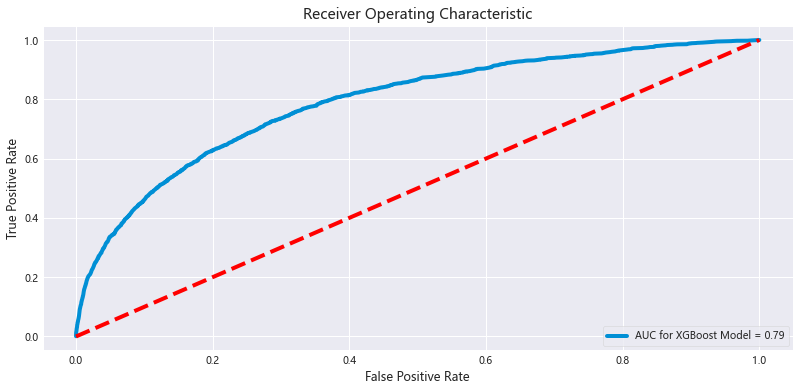

In [74]:
fpr_XGB,tpr_XGB,_ = metrics.roc_curve(y_test,yPredXGB)
ROC_AUC_XGB= metrics.auc(fpr_XGB, tpr_XGB)
plt.figure(figsize=(12,6))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr_XGB, tpr_XGB, label = 'AUC for XGBoost Model = %0.2f' % ROC_AUC_XGB)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<AxesSubplot:>

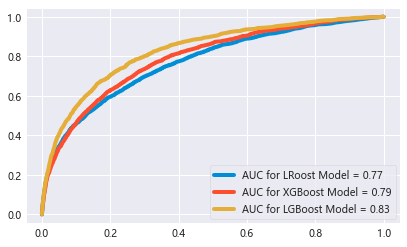

In [75]:
sns.lineplot(fpr_LR, tpr_LR, label = 'AUC for LRoost Model = %0.2f' % ROC_AUC_LR)
sns.lineplot(fpr_XGB, tpr_XGB, label = 'AUC for XGBoost Model = %0.2f' % ROC_AUC_XGB)
sns.lineplot(fpr_LGB, tpr_LGB, label = 'AUC for LGBoost Model = %0.2f' % ROC_AUC_LGB)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

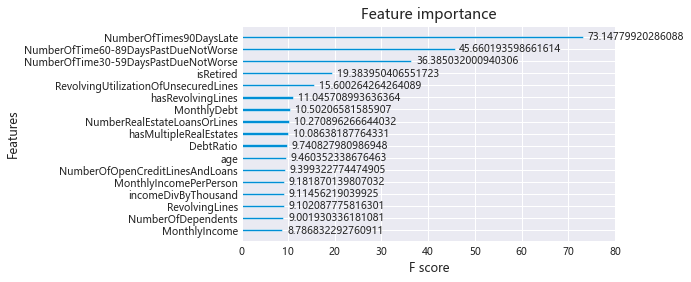

In [76]:
bestEstimatorXGB.get_booster().feature_names = trainDF.columns.to_list()
xgb.plot_importance(bestEstimatorXGB, importance_type='gain')

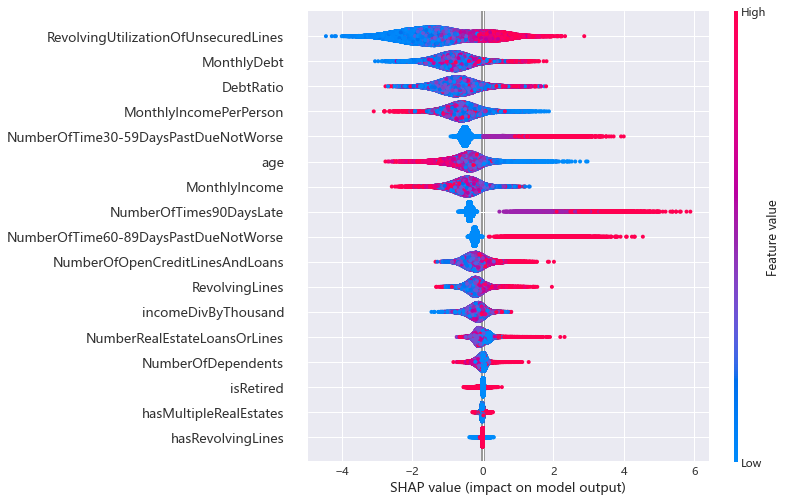

In [77]:
mybooster = bestEstimatorXGB.get_booster()
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

mybooster.save_raw = myfun


X = pd.DataFrame(X_train, columns=trainDF.columns.to_list())

explainer = shap.TreeExplainer(mybooster)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [83]:
frames = [LRMetrics,LGBMMetrics,XGBMetrics]
TrainingResult = pd.concat(frames)
TrainingResult.T

,0,1,2
Model,LogisticRegression,LightGBM,XGBoost
MSE,6.28,13.79,8.8
RMSE,2.51,3.71,2.97
MAE,6.28,13.79,8.8
MSLE,3.02,6.63,4.23
RMSLE,1.74,2.57,2.06
Accuracy Train,93.99,88.43,98.74
Accuracy Test,93.72,86.21,91.2
F-Beta Score (β=2),13.4,45.98,32.92


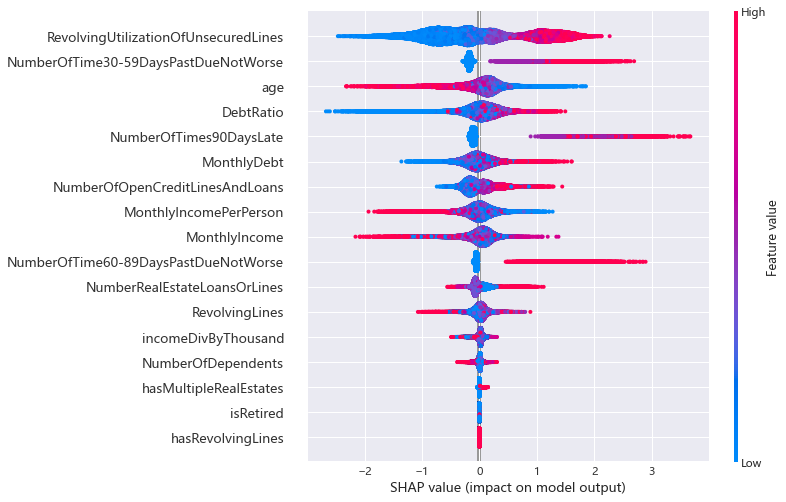

In [84]:
X = pd.DataFrame(X_train, columns=trainDF.columns.to_list())

explainer = shap.TreeExplainer(bestEstimatorLGB)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values[1], X)

总结:通过Python工具包pandas进行异常值、缺失值等数据清洗，通过构建家庭人均收入，退休人员等多项新特征提高模型预测准确率，采用主流的逻辑回归算法，基于决策树算法的LightGBM和XGBoost进行模型的拟合和随机搜索的方式进行参数优化，通过对不同算法多维度的如召回率和AUC等模型评价标准对比，用SHAP工具增强模型的可解释性，最后搭建AUC达0.83优质模型<a class="anchor" id="1"></a>